In [ ]:
!pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets efficientnet-pytorch
!pip3 install --upgrade alexnet_pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.handlers import LRScheduler, ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
import ignite.contrib.engines.common as common
import opendatasets as od
import os
from random import randint
import urllib
import zipfile
from alexnet_pytorch import AlexNet

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [25]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' 
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2023-02-05 17:47:10--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  15.7MB/s    in 19s     

2023-02-05 17:47:29 (12.8 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [26]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images))
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

In [27]:
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)
    # idx = (dataset.targets==1) | (dataset.targets==2) | (dataset.targets==3) | (dataset.targets==4)
    # dataset.targets = dataset.targets[idx]
    # dataset.data = dataset.data[idx]/
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    return dataloader

In [28]:
val_img_dir = os.path.join(VALID_DIR, 'images')
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [29]:
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [30]:
preprocess_transform_pretrain = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])])

In [31]:
batch_size = 64
train_dataloader = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform_pretrain)
test_dataloader = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform_pretrain)

In [32]:
model_alexnet = models.alexnet(pretrained=True)

In [33]:
for name, param in model_alexnet.named_parameters() :
    param.requires_grad = False
    if name.startswith('classifier') : 
        param.requires_grad = False

In [34]:
class AlexNetConv2(nn.Module):
    def init(self):
        super(AlexNetConv2, self).init()
        self.features = nn.Sequential(*list(model_alexnet.features.children())[:-7])
    def forward(self, x):
        x = self.features(x)
        return x

class AlexNetConv5(nn.Module):
    def __init__(self):
        super(AlexNetConv5, self).__init__()
        self.featuresdfd = nn.Sequential(*list(model_alexnet.features.children())[:-4])
    def forward(self, x):
        x = self.featuresdfd(x)
        return x

class AlexNetFc8(nn.Module):
    def init(self):
        super(AlexNetFc8, self).init()
        self.features = nn.Sequential(*list(model_alexnet.features.children())[:-1])
    def forward(self, x):
        x = self.features(x)
        return x

In [35]:
class MyModel_conv5(nn.Module):
  def __init__(self, model):
    super(MyModel_conv5, self).__init__()
    self.pre_trained = model
    self.seq = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1),
            nn.Conv2d(256, 256, 3, 1),
            nn.Conv2d(256, 256, 3, 1),
            nn.ConvTranspose2d(256, 256, 5, 2),
            nn.ConvTranspose2d(256, 128, 5, 2),
            nn.ConvTranspose2d(128, 64, 5, 2),
            nn.ConvTranspose2d(64, 32, 5, 2),
            nn.ConvTranspose2d(32, 3, 5, 2), 
            nn.MaxPool2d((94, 94), stride=(1, 1)), 
            )
          
  def forward(self, x):
    x = self.pre_trained(x)
    x = self.seq(x)
    return x

pre_trained = AlexNetConv5()
model = MyModel_conv5(pre_trained)

In [36]:
if torch.cuda.is_available():
    model.cuda()

In [37]:
lr = 0.001  
num_epochs = 3 
log_interval = 300
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_values = []
    model.train()
    running_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_values.append(running_loss)
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    plt.plot(np.array(loss_values), 'r')

In [39]:
def test(dataloader, model, loss_fn):
    loss_values = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
            correct += (pred.argmax(1) == X).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 1.257729  [    0/100000]
loss: 6.333055  [ 6400/100000]
loss: 1.987759  [12800/100000]
loss: 1.413734  [19200/100000]
loss: 1.384520  [25600/100000]
loss: 1.442773  [32000/100000]
loss: 1.484911  [38400/100000]
loss: 1.264908  [44800/100000]
loss: 1.304636  [51200/100000]
loss: 1.251667  [57600/100000]
loss: 1.091855  [64000/100000]
loss: 1.137109  [70400/100000]
loss: 1.184907  [76800/100000]
loss: 1.285305  [83200/100000]
loss: 1.299947  [89600/100000]
loss: 1.248004  [96000/100000]


RuntimeError: ignored

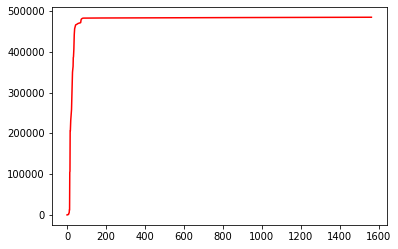

In [40]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")